Shape: (7043, 21)

Missing values:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Target distribution:
Churn
No     5174
Yes    1869
Name: count, dtype: int64


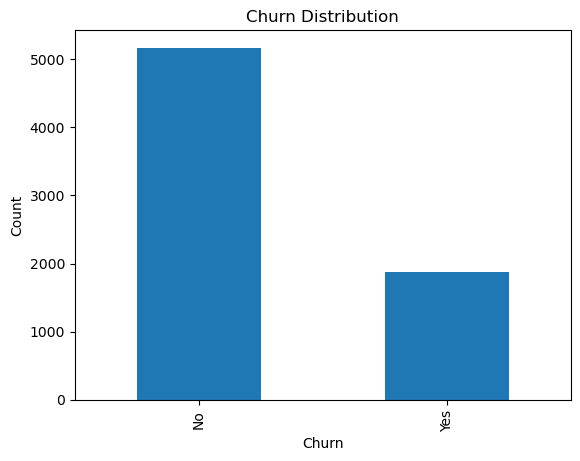

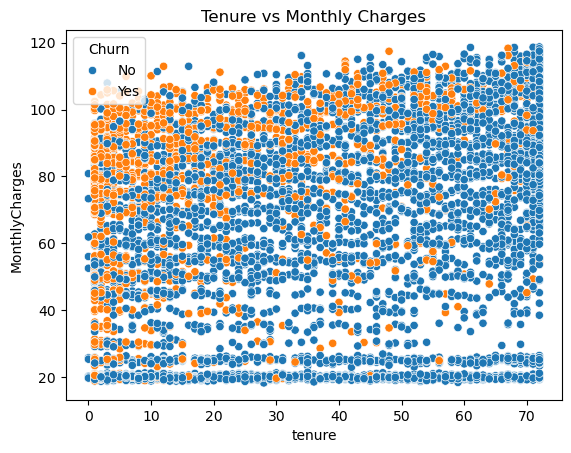

Best class_weight: None
Best threshold: 0.6158577101420735
Best recall (precision ≥ 0.70): 0.3663101604278075

Final Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.94      0.87      1033
           1       0.70      0.37      0.48       374

    accuracy                           0.79      1407
   macro avg       0.75      0.66      0.68      1407
weighted avg       0.78      0.79      0.77      1407



In [ ]:
# 1. IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, classification_report

# 2. LOAD DATASET
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# 3. MINIMUM EDA
print("Shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())

print("\nTarget distribution:")
print(df["Churn"].value_counts())

# Plot 1: Target distribution
df["Churn"].value_counts().plot(kind="bar", title="Churn Distribution")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()

# Plot 2: Tenure vs Monthly Charges
sns.scatterplot(x="tenure", y="MonthlyCharges", hue="Churn", data=df)
plt.title("Tenure vs Monthly Charges")
plt.show()

# 4. DATA CLEANING
# Drop customer ID
df.drop("customerID", axis=1, inplace=True)

# Convert target to binary
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

# Convert TotalCharges to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Drop rows with missing values
df = df.dropna()

# 5. FEATURE / TARGET SPLIT
X = df.drop("Churn", axis=1)
y = df["Churn"]

# 6. ONE-HOT ENCODING
X = pd.get_dummies(X, drop_first=True)

# 7. TRAIN / VALIDATION SPLIT
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 8. FEATURE SCALING
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 9. COST-SENSITIVE LOGISTIC REGRESSION
class_weights_list = [
    None,
    {0: 1, 1: 2},
    {0: 1, 1: 3},
    {0: 1, 1: 5}
]

best_model = None
best_weight = None
best_threshold = None
best_recall = 0

for cw in class_weights_list:
    model = LogisticRegression(
        max_iter=1000,
        class_weight=cw,
        solver="liblinear"
    )
    model.fit(X_train_scaled, y_train)

    # Predict probabilities
    y_probs = model.predict_proba(X_val_scaled)[:, 1]

    # Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_val, y_probs)

    # Select threshold where precision >= 0.70
    for p, r, t in zip(precision, recall, thresholds):
        if p >= 0.70 and r > best_recall:
            best_recall = r
            best_threshold = t
            best_model = model
            best_weight = cw

print("Best class_weight:", best_weight)
print("Best threshold:", best_threshold)
print("Best recall (precision ≥ 0.70):", best_recall)

# 10. FINAL EVALUATION AT SELECTED THRESHOLD
y_final_probs = best_model.predict_proba(X_val_scaled)[:, 1]
y_final_pred = (y_final_probs >= best_threshold).astype(int)

print("\nFinal Classification Report:\n")
print(classification_report(y_val, y_final_pred))
